## Redshift Catastrophics Analysis

This notebook analyzes redshift uncertainties in DESI mock data for the ELG_LOPnotqso tracer, focusing on the ratio of redshift catastrophics and velocity distributions. It includes:
- Calculation of redshift discrepancy ratios for `Z_realistic` and `Z_failures`
- Log-normal distribution analysis for velocity deviations in redshift catastrophics
- Comparison of n(z) distributions between fiducial and catastrophic cases

This provides insights into the systematic effects of redshift errors on clustering measurements.


In [ ]:
import os
import glob
import fitsio
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
nran_list = {'ELG_LOPnotqso':10, 'LRG':8, 'QSO':4}

survey  ='Y1'
specver ='iron'
mockver ='v4_2'
tracer  = 'ELG_LOPnotqso'
region  ='NGC' #NGC, SGC
nran = nran_list[tracer]

MOCKNUM = 0
file_path = f'/pscratch/sd/s/shengyu/mocks/{survey}/Abacus_{mockver}/altmtl{MOCKNUM}/{specver}/mock{MOCKNUM}/LSScats'
mock_type = 'clustering' #clustering or full_HPmapcut (before z selection and FKP weight assigments)

with fits.open('./example_files/ELG_LOPnotqso_NGC_clustering.dat.fits', memmap=True) as hdul:
    dat_mocks = hdul[1].data

# hdul.info()
print(dat_mocks.names, '\n', dat_mocks[:3], '\n', len(dat_mocks))

['TARGETID', 'RA', 'DEC', 'Z', 'NTILE', 'PHOTSYS', 'FRAC_TLOBS_TILES', 'Z_realistic', 'Z_failures', 'WEIGHT', 'WEIGHT_ZFAIL', 'WEIGHT_COMP', 'WEIGHT_SYS', 'NX', 'WEIGHT_FKP', 'FKP_realistic', 'FKP_failures'] 
 [(2653216, 90.397415, 65.87539 , 1.3745607, 1, 'N', 0.50325851, 1.3745607, 1.3745607, 0.32187472, 1., 1., 1., 6.67420076e-05, 0.7892859 , 0.7892859 , 0.7892859 )
 (3726838, 90.4477  , 65.900055, 1.3821355, 2, 'N', 0.70977364, 1.3821355, 1.3821355, 0.42951783, 1., 1., 1., 1.26374449e-04, 0.66423212, 0.66423212, 0.66423212)
 (2931289, 90.509575, 65.8081  , 1.2304426, 1, 'N', 0.50325851, 1.2304426, 1.2304426, 0.64374943, 1., 2., 1., 7.85776206e-05, 0.76085523, 0.76085523, 0.76085523)] 
 1813296


In [4]:
# Calculating the ratio of redshift catastrophics
z_diff = dat_mocks['Z']-dat_mocks['Z_realistic']

print('initial:',len(z_diff))
print('dz nonzero:',len(z_diff[np.nonzero(z_diff)]))
print('abs(dz)>0.01:',len(z_diff[np.abs(z_diff)>0.01]))
print('abs(dz)>0.001:',len(z_diff[np.abs(z_diff)>0.001]))

print('Z_realistic ratio:', len(z_diff[np.abs(z_diff)>0.01])/len(z_diff))
z_diff = dat_mocks['Z']-dat_mocks['Z_failures']
# print(Z_diff[np.nonzero(Z_diff)])
print('Z_failures ratio:',len(z_diff[np.abs(z_diff)>0.01])/len(z_diff))

initial: 1813296
dz nonzero: 5043
abs(dz)>0.01: 4988
abs(dz)>0.001: 5039
Z_realistic ratio: 0.0027507919280691075
Z_failures ratio: 0.010366206068948478


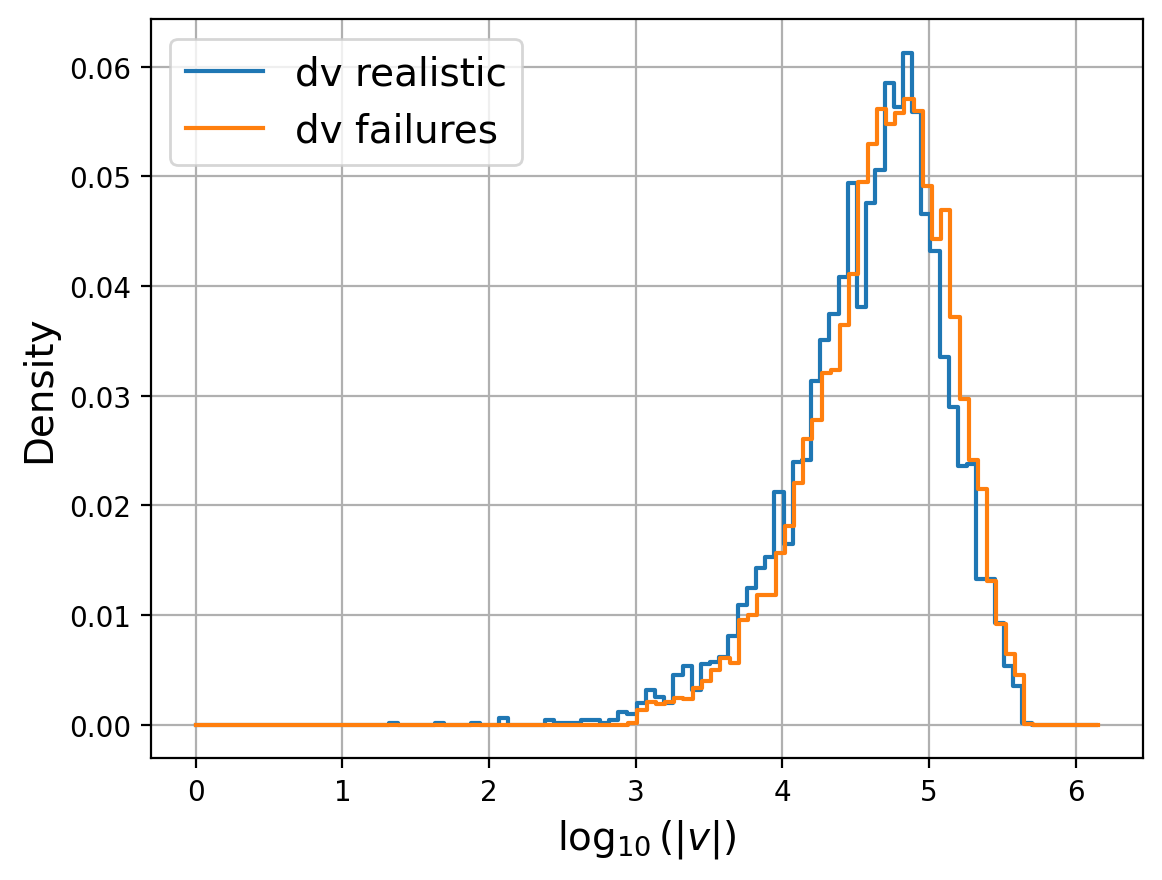

In [5]:
# dv distribution (should be a log-normal distribution for the redshift catastrophics)
def plot_bins(data, bins=None, num_bins=100):
    if bins == None:
        bins = np.linspace(0, max(data)*(1.1), num_bins)
    n, bin_edges = np.histogram(data, bins=bins)
    n_rs = n / np.sum(n)
    return(bin_edges[:-1],n_rs)

c = 299792 # speed of light in km/s
dv_labels = ['dv realistic', 'dv failures']
for i,zcatas_fn in enumerate(['Z_realistic', 'Z_failures']):
    z_diff = dat_mocks['Z']-dat_mocks[zcatas_fn]
    delta_z = z_diff[np.nonzero(z_diff)]
    delta_v = abs(delta_z*c/(1+dat_mocks['Z'][np.nonzero(z_diff)]))
    log_delta_v = np.log10(delta_v)
    (x,y)=plot_bins(log_delta_v)
    plt.plot(x, y, drawstyle='steps-post',label=dv_labels[i])
plt.legend()
plt.ylabel(r'Density')
plt.grid(True)
plt.xlabel(r'$\log_{10}(|v|)$')
plt.show()

3


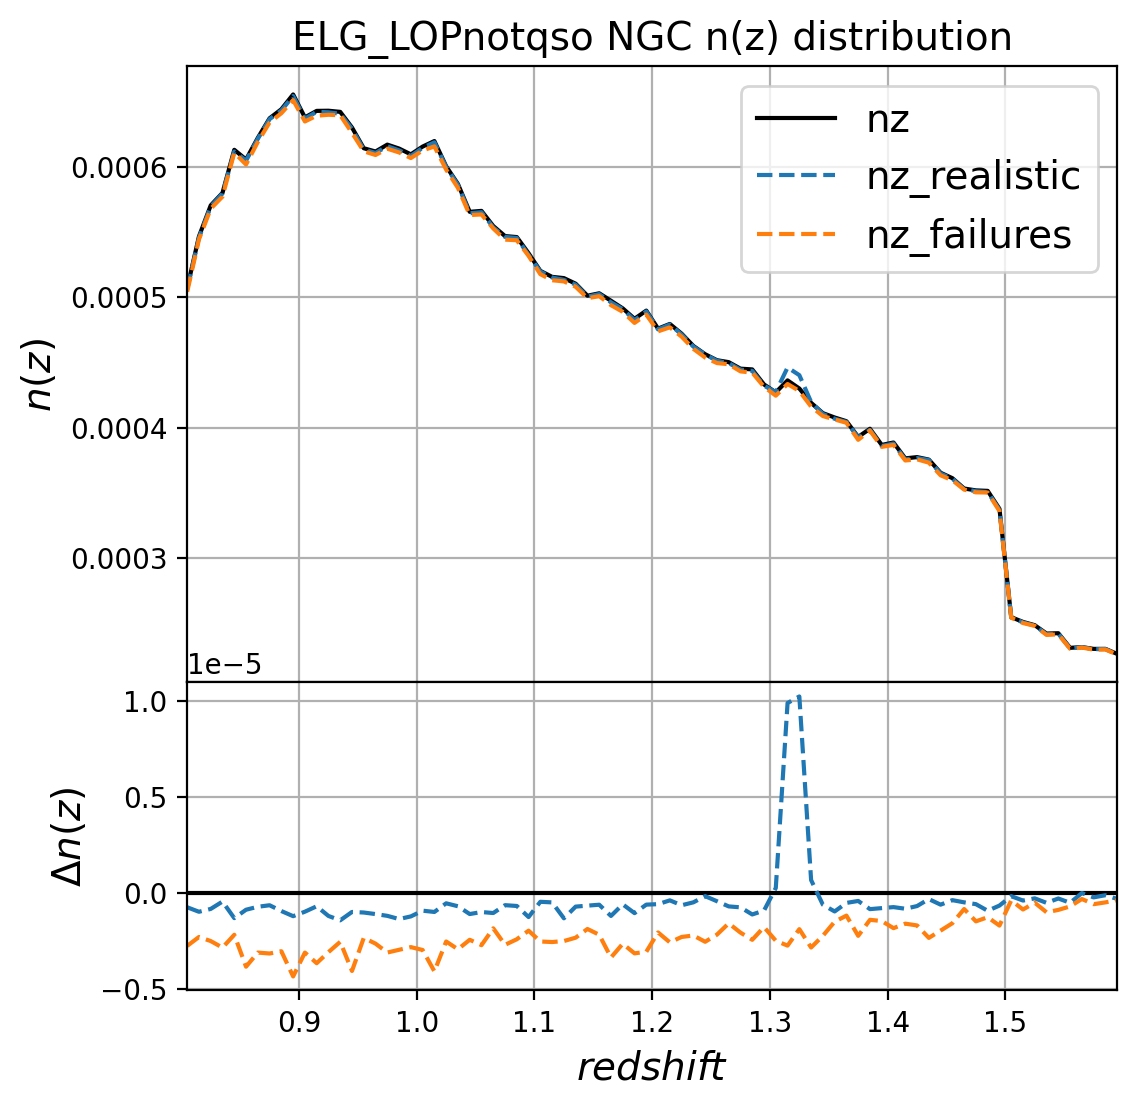

In [6]:
#zmid zlow zhigh n(z) Nbin Vol_bin
nz_columes = {'n(z)':3, 'Nbin':4, 'Vol_bin':5}

nplot = 'n(z)'
colume = nz_columes[nplot]
print(colume)
z_labels = ['nz', 'nz_realistic','nz_failures']
fig, ax = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1], 'hspace': 0}, sharex=True)
for i,nz_fn in enumerate(z_labels):
    nz = np.loadtxt(f'./example_files/{tracer}_{region}_{nz_fn}.txt')
    if i == 0:
        nz_fiducial = nz
        zmid = nz_fiducial[:,0]
        ax[0].set_xlim(min(nz[:,0]), max(nz[:,0]))
        ax[0].plot(zmid,nz_fiducial[:,colume],color='black', label=z_labels[i])
        ax[1].plot(zmid, [0]*len(zmid),color='black')
    if i>0:
        nz_catas = nz
        ax[0].plot(zmid, nz_catas[:,colume], label=z_labels[i], ls='--')
        ax[1].plot(zmid, nz_catas[:,colume]-nz_fiducial[:,colume], ls='--')

ax[0].set_title(f'{tracer} {region} {nplot} distribution')
ax[0].legend()
ax[0].grid(True)
ax[1].grid(True)
ax[1].set_xlabel(r'$redshift$')
ax[0].set_ylabel(r'$n(z)$')
ax[1].set_ylabel(r'$\Delta n(z)$')
plt.show()